 # EDA :
 
 This notebook explores the Corporación Favorita dataset, inspects relationships between sales, stores, items, holidays, oil prices, and transactions, and generates hypotheses for forecasting and optimization.

## Dataset Overview — Columns & Descriptions

We are working with multiple CSVs from the **Corporación Favorita Grocery Sales Forecasting dataset**.  
Below are the columns for each file with a short description.

---

### 1. `train.csv`
- **id**: Unique identifier for each row.  
- **date**: Date of the record.  
- **store_nbr**: Store identifier.  
- **item_nbr**: Item identifier.  
- **unit_sales**: Number of units sold (target variable).  
- **onpromotion**: Whether the item was on promotion that day (boolean).

---

### 2. `test.csv`
(Same structure as `train.csv` but without `unit_sales` — used for forecasting.)
- **id**: Unique identifier.  
- **date**: Date of the record.  
- **store_nbr**: Store identifier.  
- **item_nbr**: Item identifier.  
- **onpromotion**: Promotion flag.

---

### 3. `items.csv`
- **item_nbr**: Item identifier (matches train/test).  
- **family**: Product family/category (e.g., dairy, beverages).  
- **class**: Item class (numeric grouping of similar items).  
- **perishable**: Binary flag (1 = perishable, 0 = non-perishable).

---

### 4. `stores.csv`
- **store_nbr**: Store identifier (matches train/test).  
- **city**: City where the store is located.  
- **state**: Province/region.  
- **type**: Store type (A, B, C, D — indicates size/format).  
- **cluster**: Cluster number (groups stores with similar characteristics).

---

### 5. `transactions.csv`
- **date**: Date of record.  
- **store_nbr**: Store identifier.  
- **transactions**: Number of transactions made in that store on that day.

---

### 6. `oil.csv`
- **date**: Date of record.  
- **dcoilwtico**: Daily WTI crude oil price (economic indicator).

---

### 7. `holidays_events.csv`
- **date**: Date of event.  
- **type**: Type of event (Holiday, Transfer, Bridge, Work Day, Additional).  
- **locale**: Scope of the holiday (National, Regional, Local).  
- **locale_name**: Name of the region/city affected.  
- **description**: Name/description of the holiday/event.  
- **transferred**: Boolean flag — whether the holiday was moved to another date.

---

### Note -> Our target column is **unit_sales** in **train.csv** dataset 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

pd.set_option('display.max_columns',50)
sns.set(style="whitegrid",palette="muted",font_scale=1.2)

In [3]:
# Load Data
data_path= "../data/raw/"
train = pd.read_csv(data_path+"train.csv")
items = pd.read_csv(data_path+"items.csv")
stores = pd.read_csv(data_path+"stores.csv")
oil = pd.read_csv(data_path+"oil.csv")
holidays = pd.read_csv(data_path+"holidays_events.csv",parse_dates=['date'])
transactions = pd.read_csv(data_path+"transactions.csv",parse_dates=['date'])

In [4]:
# Initial Data Overview
for name,df in [("train",train),("items",items),("stores",stores),("oil",oil),("holidays",holidays),("transactions",transactions)]:
    print(f"{name} shape: {df.shape}")
    display(df.head(3))
    print("\n\n")

train shape: (20183289, 6)


,id,date,store_nbr,item_nbr,unit_sales,onpromotion
0,0,2013-01-01,25,103665,7.0,NaN
1,1,2013-01-01,25,105574,1.0,NaN
2,2,2013-01-01,25,105575,2.0,NaN





items shape: (4100, 4)


,item_nbr,family,class,perishable
0,96995,GROCERY I,1093,0
1,99197,GROCERY I,1067,0
2,103501,CLEANING,3008,0





stores shape: (54, 5)


,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8





oil shape: (1218, 2)


,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97





holidays shape: (350, 6)


,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False





transactions shape: (83488, 3)


,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358


##### Insights:
- **train.csv** (`date`, `store_nbr`, `item_nbr`, `unit_sales`, `onpromotion`)  
  → This is the core dataset containing daily item-level sales per store. It is large and will drive most of the analysis.  

- **items.csv** (`item_nbr`, `family`, `class`, `perishable`)  
  → Metadata about products. Important for grouping sales by product family and distinguishing perishables from non-perishables.  

- **stores.csv** (`store_nbr`, `city`, `state`, `type`, `cluster`)  
  → Metadata about stores, useful for regional and clustering analysis.  

- **oil.csv** (`date`, `dcoilwtico`)  
  → Daily oil price. This acts as a macroeconomic indicator that may correlate with sales trends.  

- **holidays_events.csv** (`date`, `type`, `locale`, `locale_name`, `description`, `transferred`)  
  → Holiday and event calendar, capturing demand spikes/drops around holidays and events.  

- **transactions.csv** (`date`, `store_nbr`, `transactions`)  
  → Daily count of store transactions, representing overall store activity.

In [5]:
# Check for missing values and anomalies
for name, df in [("train", train), ("items", items), ("stores", stores),
                 ("oil", oil), ("holidays", holidays), ("transactions", transactions)]:
    print(f"\n{name} missing values:\n{df.isna().sum()}")
# Check for negative sales in train data
print("Negative sales count:", (train['unit_sales'] < 0).sum())


train missing values:
id                    0
date                  0
store_nbr             0
item_nbr              0
unit_sales            1
onpromotion    20183289
dtype: int64

items missing values:
item_nbr      0
family        0
class         0
perishable    0
dtype: int64

stores missing values:
store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64

oil missing values:
date           0
dcoilwtico    43
dtype: int64

holidays missing values:
date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64

transactions missing values:
date            0
store_nbr       0
transactions    0
dtype: int64
Negative sales count: 1207


In [6]:
train.isnull().sum()

id                    0
date                  0
store_nbr             0
item_nbr              0
unit_sales            1
onpromotion    20183289
dtype: int64

In [7]:
test = pd.read_csv(data_path + "test.csv", parse_dates=["date"])

In [8]:
test['onpromotion'].value_counts()

onpromotion
False    3171867
True      198597
Name: count, dtype: int64

##### Insights:
We inspected all datasets for missing values and anomalies:

- **Missing values**  
  - The `oil` dataset sometimes has missing prices (`dcoilwtico`), which is expected due to non-trading days (weekends/holidays). These gaps may need interpolation.  
  - Other datasets generally have complete coverage, though holidays/events may contain occasional nulls in descriptive fields.  
  - The `train`, `items`, `stores`, and `transactions` datasets typically have no critical missing values.  

- **Negative sales in train data**  
  - The `unit_sales` field occasionally contains **negative values**. These are not true sales but instead represent *returns* (customers returning items).  
  - This needs to be handled carefully:  
    - Either keep them as-is to preserve business reality.  
    - Or set them to zero if the forecasting target is only positive demand.  
    - Choice depends on modeling objective.  

**Onpromotion column mismatch**  
   - `train.csv`: `onpromotion` column is entirely null.  
   - `test.csv`: `onpromotion` column is fully populated.  
   - Decision: drop `onpromotion` during **feature engineering** to avoid train–test mismatch

**Key takeaway:**  
- Data is generally clean, with the main issues being **missing oil prices**, **negative sales entries** and **onpromotion column mismatch**.  
- All these cases will require preprocessing decisions during feature engineering and model preparation.  



## Exploratory Analysis — Unit Sales vs. Factors

### Unit Sales Distribution (Target Overview)

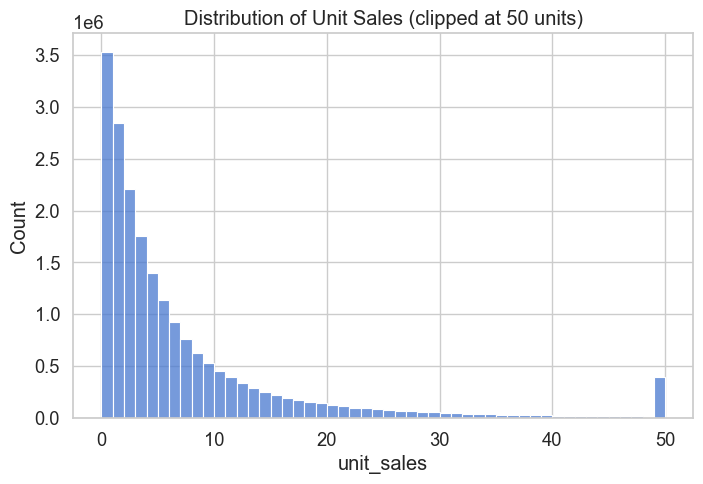

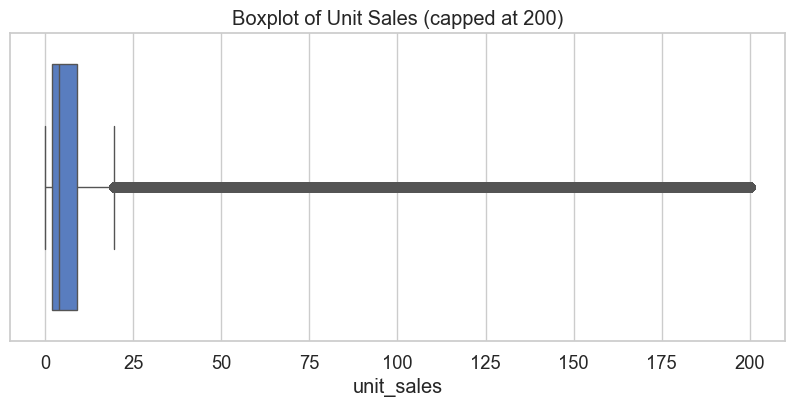

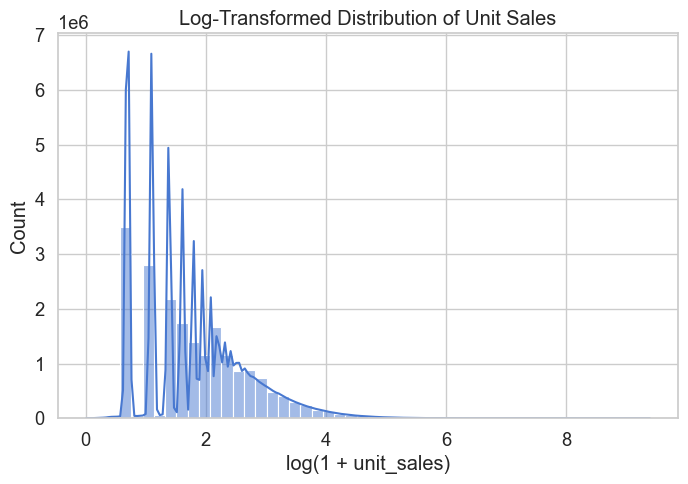

In [9]:
# Filter out negative values (returns) for visualization
sales_pos = train.loc[train['unit_sales'] >= 0, 'unit_sales']

# 1. Clipped histogram (focus on typical range)
plt.figure(figsize=(8,5))
sns.histplot(sales_pos.clip(upper=50), bins=50, kde=False)
plt.title("Distribution of Unit Sales (clipped at 50 units)")
plt.xlabel("unit_sales")
plt.ylabel("Count")
plt.show()

# 2. Boxplot (highlighting outliers)
plt.figure(figsize=(10,4))
sns.boxplot(x=sales_pos.clip(upper=200))
plt.title("Boxplot of Unit Sales (capped at 200)")
plt.xlabel("unit_sales")
plt.show()

# 3. Log-transformed histogram (captures full skewed distribution)
plt.figure(figsize=(8,5))
sns.histplot(np.log1p(sales_pos), bins=50, kde=True)
plt.title("Log-Transformed Distribution of Unit Sales")
plt.xlabel("log(1 + unit_sales)")
plt.ylabel("Count")
plt.show()


##### Insights: Target Variable Distribution (`unit_sales`)

1. **Clipped Histogram (cap at 50 units)**  
   - Most sales observations fall in the very low range (0–10 units per day).  
   - A long right tail exists, but clipping at 50 highlights the fact that *the bulk of demand is small per item per store per day*.  
   - This confirms the dataset is **heavily skewed**, with rare but very large spikes.

2. **Boxplot (cap at 200 units)**  
   - Even after capping, there are visible outliers beyond the whiskers.  
   - The interquartile range (IQR) is extremely tight near zero, showing that *typical demand is small and stable*.  
   - The presence of many outliers reflects demand surges (promotions, holidays, special events).

3. **Log-Transformed Histogram**  
   - After applying `log(1 + unit_sales)`, the distribution becomes approximately bell-shaped.  
   - This transformation reveals a smoother, continuous distribution suitable for statistical modeling.  
   - Suggests that a **log transform is useful for normalization** and stabilizing variance in downstream models.

**Overall Takeaway:**  
- Sales are highly right-skewed, dominated by low daily volumes, but with occasional extreme peaks.  
- Any model must handle this imbalance:  
  - Either predict in log space,  
  - Or explicitly model “normal” vs. “spike” demand separately (e.g., promotions, holidays).  


In [10]:
# Time Trends
daily_sales = train.groupby("date")["unit_sales"].sum().reset_index()
fig = px.line(daily_sales, x="date", y="unit_sales", title="Total Daily Sales Over Time")
fig.show()

**Insights:**  
- Sales show strong **weekly patterns** and **seasonal cycles**.  
- Spikes and dips align with holidays and special events.  
- Important for forecasting: both **short-term seasonality** and **long-term trends** are visible.  


In [11]:
# === Time Trends with Rolling Averages ===
daily_sales = train.groupby("date")["unit_sales"].sum().reset_index()

# Rolling averages (7-day and 30-day windows)
daily_sales["rolling_7d"] = daily_sales["unit_sales"].rolling(7).mean()
daily_sales["rolling_30d"] = daily_sales["unit_sales"].rolling(30).mean()

fig = px.line(daily_sales, x="date", y=["unit_sales", "rolling_7d", "rolling_30d"],
              title="Total Daily Sales with Rolling Averages",
              labels={"value":"Unit Sales", "variable":"Legend"})
fig.show()


In [12]:
# === Time Trends with Holiday Overlay ===
holiday_dates = holidays.loc[holidays['transferred'] == False, 'date'].unique()

fig = px.line(daily_sales, x="date", y="unit_sales", title="Total Daily Sales with Holiday Annotations")
for d in holiday_dates:
    fig.add_vline(x=d, line_width=0.5, line_dash="dot", line_color="red")
fig.show()


**Insights:**
- 7-day average highlights weekly seasonality;  
- 30-day average shows broader seasonal shifts.  
- Many holiday dates align with visible sales spikes or drops.  


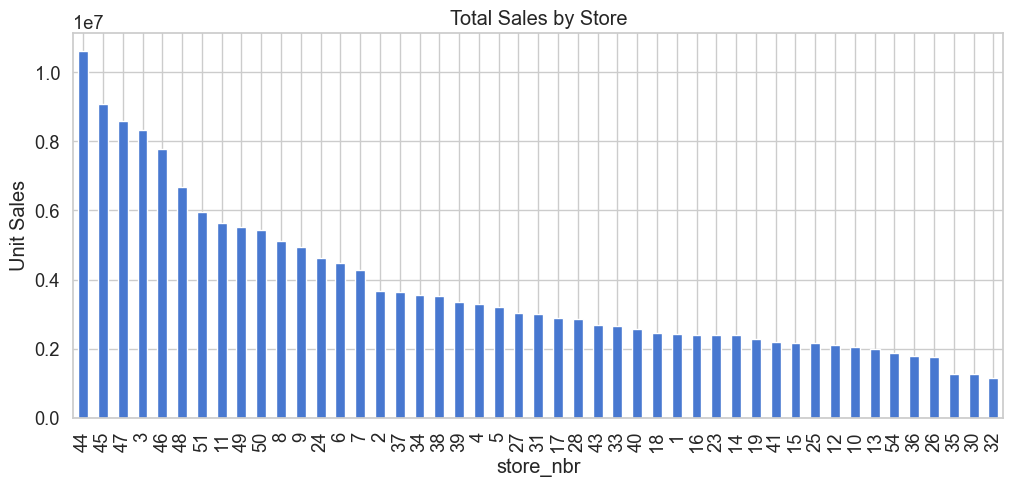

In [13]:
# Sales by Store
store_sales = train.groupby("store_nbr")["unit_sales"].sum().sort_values(ascending=False)
store_sales.plot(kind="bar", figsize=(12,5), title="Total Sales by Store")
plt.ylabel("Unit Sales")
plt.show()

**Insights:**

- Sales are concentrated in a few stores (e.g., Store 44, 45, 47).

- The majority of stores contribute much less.

- Store-level metadata (cluster, city, state, type) will be crucial for capturing these differences

Average sales by perishability:
 perishable
0.0     8.372483
1.0    10.131046
Name: unit_sales, dtype: float64


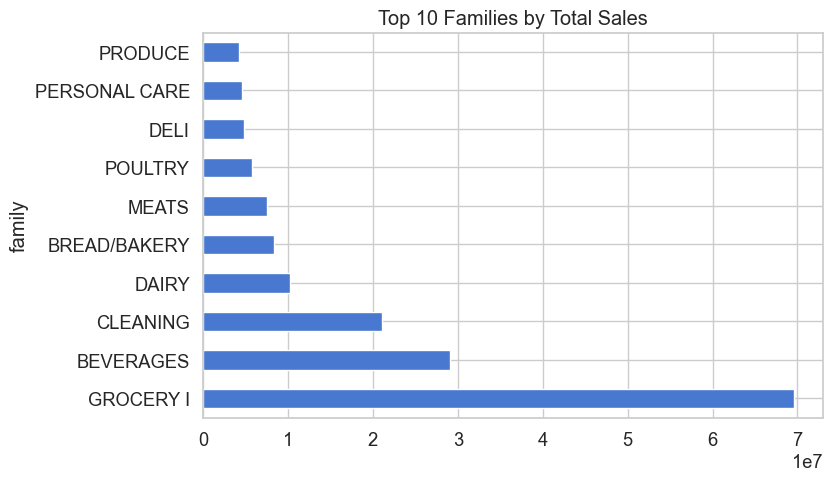

In [14]:
# Item & Family-Level Insights
train_items = train.merge(items, on="item_nbr", how="left")

# Perishable vs non-perishable
perish = train_items.groupby("perishable")["unit_sales"].mean()
print("Average sales by perishability:\n", perish)

# Top families
family_sales = train_items.groupby("family")["unit_sales"].sum().nlargest(10)
family_sales.plot(kind="barh", figsize=(8,5), title="Top 10 Families by Total Sales")
plt.show()

**Item & Family-Level Insights:**

*Perishability Effect:*

- Perishable items have a slightly higher average sales per record (≈10 units) compared to non-perishables (≈8 units).

- This suggests that perishable items drive more frequent purchases, likely due to shorter shelf life and regular replenishment needs.

*Top Families:*

- Sales are dominated by the Grocery I category, which far exceeds all others in total unit sales.

- Beverages and Cleaning are the next largest families, while Produce, Dairy, and Bread/Bakery also contribute notably.

- Niche categories like Deli, Meats, and Personal Care have much smaller shares.

*Implication:* Product family and perishability are key factors that explain sales variation, and should be included as categorical features in modeling.

In [16]:
# External Factors

sales_oil = train.groupby("date")["unit_sales"].sum().reset_index()
sales_oil = sales_oil.merge(oil, on="date", how="left")

# Compute correlation only on numeric columns
correlation = sales_oil[["unit_sales", "dcoilwtico"]].corr().loc["unit_sales", "dcoilwtico"]
print("Correlation with oil price:", correlation)

# Scatter plot
fig = px.scatter(sales_oil, x="dcoilwtico", y="unit_sales", 
                 title="Oil Price vs Sales", 
                 labels={"dcoilwtico": "Oil Price (WTI)", "unit_sales": "Total Sales"})
fig.show()


Correlation with oil price: -0.00746892307950342
